# GANs &ndash; Part 3: Adversarial domain adaptation (SVHN &rarr; MNIST)

Author: Sebastian Bujwid <bujwid@kth.se>

Refer to [./README.md](./README.md) for general comments.

## Scope

- Train a CNN on SVHN digits classification. Evaluate it on MNIST (same classes)
- Implement and train an adversarial domain adaptation model [DANN](https://www.jmlr.org/papers/volume17/15-239/15-239.pdf). The model trains on SVHN data together with MNIST samples without labels. Evaluate the trained model on MNIST

<div align="center">
    <img src="./imgs/svhn_and_mnist.png"/>
    SVHN and MNIST digits
</div>

## Domain adaptation

A model trained on data source would often perform the same task much worse on data from a different source (different data distribution). Consider, for example, a digit classifier trained on SVHN and evaluated on MNIST, as in this part of the practical.

The goal of domain adaptation is to use source domain data (SVHN in our case) to train a model that works well on the target domain (MNIST in our case). In domain adaptation, we consider source and target tasks to be the same (classification of digits). In this setting, one typically assumes access to target domain samples but not their labels.

Domain adaptation can be especially beneficial when source domain data is easily available but target data is difficult to label.
Many factors might cause the difficulty of labeling target data.
It could be because labeling target data is just too costly. Consider, for example, the cost of labeling real (target) data for training a robot, compared to using automatically extracting ground-truth from a robot simulator (e.g., [GraspGAN](https://ieeexplore.ieee.org/document/8460875), [GANerated Hands](https://handtracker.mpi-inf.mpg.de/projects/GANeratedHands/content/GANeratedHands_CVPR2018.pdf)), or medical data that requires specialized domain knowledge to annotate and data from different facilities or capturing devices (such as CT scans) can have noticeable differences (e.g., [Mahmood _et al_. (2018)](https://ieeexplore.ieee.org/document/8370747), [Chen _et al._ (2019)](https://arxiv.org/abs/1901.08211)).
But the challenges of labeling target data can also be due to time constraints when conditions quickly change (e.g., a pandemic), or in extreme cases, the conditions might change (e.g., problem difficulty increasing) even as a result of deploying a model that has a direct or indirect impact on the environment (e.g., consider social media companies using "AI" to detect hate speech, etc.).

There exist different domain adaptation approaches. In this practical, however, we will only use an adversarial domain adaptation where a discriminator is used to force the model to learn domain-invariant representation (similar for between the source & target domains). That should hopefully make the model overfit less to the source domain.

In [1]:
try:
    from omegaconf import OmegaConf
except ModuleNotFoundError:
    %pip install omegaconf
    from omegaconf import OmegaConf

In [2]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers, stax
from jax import jit

In [3]:
jax.devices()

[CpuDevice(id=0)]

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
seed = 42

# Implementation

## Loading data

In [7]:
def mnist_to_svhn_format(images):
    return tf.image.grayscale_to_rgb(
        tf.image.resize(images, [32 ,32])
    )

def preprocess_imgs(images):
    return tf.image.per_image_standardization(
        tf.cast(images, tf.float32) / 255.,
    )

In [ ]:
def mnist_dataset(data):
    ds = data.map(lambda x: (preprocess_imgs(mnist_to_svhn_format(x['image'])), x['label']),
                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()  # You might want to remove it if have little memory
    ds = ds.shuffle(100000)
    return ds

def svhn_dataset(data):
    ds = data.map(lambda x: (preprocess_imgs(x['image']), x['label']),
                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()  # You might want to remove it if have little memory
    ds = ds.shuffle(100000)
    return ds

data_mnist, data_mnist_dev = tfds.load(
    'mnist',
    split=['train[:50%]', 'train[50%:]'],
    shuffle_files=True,
    data_dir='./data_dir')
data_mnist_test = tfds.load('mnist', split='test', shuffle_files=True,
                            data_dir='./data_dir')

data_svhn = tfds.load('svhn_cropped', split='train', shuffle_files=True,
                      data_dir='./data_dir')
data_svhn_test = tfds.load('svhn_cropped', split='test', shuffle_files=True,
                           data_dir='./data_dir')

ds_mnist = mnist_dataset(data_mnist)
ds_mnist_dev = mnist_dataset(data_mnist_dev)
ds_mnist_test = mnist_dataset(data_mnist_test)

ds_svhn = svhn_dataset(data_svhn)
ds_svhn_test = svhn_dataset(data_svhn_test)

' ds_mnist = mnist_dataset(data_mnist)\nds_mnist_dev = mnist_dataset(data_mnist_dev)\nds_mnist_test = mnist_dataset(data_mnist_test)\n\nds_svhn = svhn_dataset(data_svhn)\nds_svhn_test = svhn_dataset(data_svhn_test) '

## (Task) Implement `sparse_softmax_cross_entropy` function

The function should compute the cross-entropy between the input `targets` and softmax of the `logits` (or be equivalent to these operations).
"Sparse" refers to the `targets` being `int` values indicating target classes and not probability distributions over all class values.

Similarly, to `sigmoid_cross_entropy` from Part 1, implementing softmax + cross-entropy as a single function can be beneficial.

Let $K$ be the number of classes. We find that


\begin{align*}
L(y, \hat{\beta}) &= -\sum_{k = 1}^K I(y=k)\log(\text{softmax}(\hat{\beta})_k)\\
    &= -\sum_{k=1}^K I(y=k)\left(\hat{\beta}_k -\log\sum_{j=1}^K\exp{\hat{\beta}_j}\right)\\
    &= \log\sum_{j=1}^K\exp{\hat{\beta}_j} - \hat{\beta}_y\\

\end{align*}

In [9]:
def sparse_softmax_cross_entropy(*, targets, logits):
    assert targets.ndim == logits.ndim - 1
    
    n_classes = logits.shape[-1]
    return(jax.nn.logsumexp(logits, axis=-1) - logits[jnp.arange(logits.shape[0]), targets])

    raise NotImplementedError('Task: implement!')

### (Task) Test the `sparse_softmax_cross_entropy` function

In [10]:
logits = jnp.array(
    [
        [-0.12, -5., 4.2, -1.],
        [0.42, 0.13, -0.1, -0.48],
        [0.1, 0.2, 0.3, 0.4,],
    ]
)
targets = jnp.array([0, 3, 2])
returned = sparse_softmax_cross_entropy(targets=targets, logits=logits)

expected_mean_ce_loss = 2.53088073318352
np.testing.assert_allclose(expected_mean_ce_loss, jnp.mean(returned))

### (Optional task) Numerically stable `sparse_softmax_cross_entropy` loss

Can you implement the function such that it logits with a very large magnitude? Try rewriting the entire expression! Think of over- and underflows!

Hint: You might find `jax.nn.logsumexp` useful!

In [11]:
returned = sparse_softmax_cross_entropy(targets=targets, logits=logits * 1000.)

expected_mean_ce_loss = 1773.3333333333333
np.testing.assert_allclose(expected_mean_ce_loss, jnp.mean(returned))

## Training CNN classifier on SVHN classification

In [12]:
w_init = jax.nn.initializers.normal(stddev=0.02)

def create_cnn():
    return  stax.serial(
        stax.Conv(128, (3, 3), padding='SAME', W_init=w_init),
        stax.BatchNorm(),
        stax.LeakyRelu,
        
        stax.Conv(128, (3, 3), padding='SAME', W_init=w_init),
        stax.BatchNorm(),
        stax.LeakyRelu,
         
        stax.Conv(128, (3, 3), strides=(2, 2), padding='SAME', W_init=w_init),
        stax.BatchNorm(),
        stax.LeakyRelu,
         
        stax.Conv(256, (3, 3), padding='SAME', W_init=w_init),
        stax.BatchNorm(),
        stax.LeakyRelu,
         
        stax.Conv(256, (3, 3), padding='SAME', W_init=w_init),
        stax.BatchNorm(),
        stax.LeakyRelu,
        
        stax.Conv(256, (3, 3), strides=(2, 2), padding='SAME', W_init=w_init),
        stax.BatchNorm(),
        stax.LeakyRelu,
        
        stax.Conv(512, (3, 3), padding='SAME', W_init=w_init),
        stax.BatchNorm(),
        stax.LeakyRelu,
         
        stax.Conv(256, (3, 3), padding='SAME', W_init=w_init),
        stax.BatchNorm(),
        stax.LeakyRelu,
         
        stax.Conv(128, (3, 3), strides=(2, 2), padding='SAME', W_init=w_init),
        stax.BatchNorm(),
        stax.LeakyRelu,
         
        stax.AvgPool(window_shape=(4, 4)),
        
        stax.Flatten
    )

def create_label_predictor():
    return stax.serial(
        stax.Dense(128, W_init=w_init), stax.BatchNorm(axis=0), stax.LeakyRelu,
        stax.Dense(128, W_init=w_init), stax.LeakyRelu,
        stax.Dense(10, W_init=w_init)
    )


In [13]:
def plot_metrics(metrics_dict, title=None):
    fig, axs = plt.subplots(1, len(metrics_dict))
    if title:
        fig.suptitle(title)
    for i, (key, vals) in enumerate(metrics_dict.items()):
        marker = 'o' if 'epoch' in key else None
        axs[i].plot(vals, marker=marker)
        axs[i].set_title(key)
        if 'acc' in key:
            axs[i].set_ylim([0, 1.1])
    plt.show()

In [14]:
def accuracy(a, b):
    return jnp.mean(a == b)

In [15]:
import tqdm
import functools
from IPython.display import clear_output

In [16]:
def create_and_train_classifier(hparams, data, eval_data=None):
    
    cnn_init, cnn_apply = create_cnn()
    dense_init, dense_apply = create_label_predictor()
    
    key = jax.random.PRNGKey(seed)
    key, key_cnn, key_pred = jax.random.split(key, 3)
    data_input_shape = (-1, 32, 32, 3)
    cnn_output_shape, cnn_params = cnn_init(key_cnn, data_input_shape)
    _, dense_params = dense_init(key_pred, cnn_output_shape)
    
    def split_params(params):
        return params[:len(cnn_params)], params[len(cnn_params):]
    
    opt_init, opt_update, get_params = optimizers.adam(
        step_size=hparams.lr, b1=hparams.beta1
    )
    opt_state = opt_init(cnn_params + dense_params)
    
    def loss_fn(cnn_params, dense_params, x, y):
        pred_y_logits = dense_apply(dense_params, cnn_apply(cnn_params, x))
        loss = jnp.mean(
            sparse_softmax_cross_entropy(targets=y, logits=pred_y_logits),
            axis=0
        )
        return loss, pred_y_logits
    
    def evaluate(opt_state, eval_data):
        cnn_params, dense_params = split_params(get_params(opt_state))
        
        loss_fn_jit = jax.jit(loss_fn)
        
        loss_vals, acc_vals = [], []
        for i, (x, y) in enumerate(tqdm.tqdm(
            tfds.as_numpy(eval_data.batch(hparams.batch_size).prefetch(tf.data.experimental.AUTOTUNE)),
            desc='evaluation'
        )):
            loss, pred_y_logits = loss_fn_jit(cnn_params, dense_params, x, y)
            acc = accuracy(y, jnp.argmax(pred_y_logits, axis=-1))
            loss_vals.append(loss)
            acc_vals.append(acc)
            
        return jnp.array(loss_vals).mean(), jnp.array(acc_vals).mean()
    
    @jax.jit
    def train_step(step, opt_state, x, y):
        cnn_params, dense_params = split_params(get_params(opt_state))
        
        (loss, pred_y_logits), (cnn_grads, dense_grads) = jax.value_and_grad(
            loss_fn, argnums=(0, 1), has_aux=True)(cnn_params, dense_params, x ,y)
        
        opt_state = opt_update(step, cnn_grads + dense_grads, opt_state)
        return loss, pred_y_logits, opt_state
    
    
    metrics = {'loss': [], 'acc': []}
    eval_metrics = {'epoch_loss': [], 'epoch_acc': []}
    best_model = {'epoch': -1, 'eval_acc': -1., 'opt_state': None}
    
    try:
        total_step = 0
        for epoch in range(hparams.epochs):
            for x, y in tqdm.tqdm(
                tfds.as_numpy(data.batch(hparams.batch_size).prefetch(tf.data.experimental.AUTOTUNE)),
                desc='training'
            ):
                
                loss, pred_y_logits, opt_state = train_step(total_step, opt_state, x, y)
                acc = accuracy(y, jnp.argmax(pred_y_logits, axis=-1))
                metrics['loss'].append(loss)
                metrics['acc'].append(acc)
                
                total_step += 1
                
            if eval_data is not None:
                eval_loss, eval_acc = evaluate(opt_state, eval_data=eval_data)
                eval_metrics['epoch_loss'].append(eval_loss)
                eval_metrics['epoch_acc'].append(eval_acc)
                if eval_acc > best_model['eval_acc']:
                    best_model = {'epoch': epoch, 'eval_acc': eval_acc, 'opt_state': opt_state}
                
            clear_output()
            print('-' * 30, 'epoch', epoch, '-' * 30)
            plot_metrics(metrics, title='Train')
            if eval_data is not None:
                plot_metrics(eval_metrics, title='Eval')
                print(f'Eval_metrics: epoch_loss {eval_metrics["epoch_loss"][-1]}'
                      f'\tepoch_acc {eval_metrics["epoch_acc"][-1]}')
        
    except KeyboardInterrupt:
        print(f'Interrupted at epoch {epoch}.')

    print(f'Returning model from epoch: {best_model["epoch"]}, eval_acc: {best_model["eval_acc"]}')
    return functools.partial(evaluate, best_model['opt_state'])

First, let's train a CNN on SVHN and measure it's performance on the SVHN test set during training.

In [17]:
hparams = OmegaConf.create({
    'epochs': 100,
    'batch_size': 128,
    'lr': 0.001,
    'beta1': 0.99,
})
eval_fn = create_and_train_classifier(hparams, ds_svhn, eval_data=ds_svhn_test) 

NameError: name 'ds_svhn' is not defined

As you hopefully see, the model achieves pretty high accuracy on SVHN ($\sim94.7\%$).

Now, let's evaluate the trained model on MNIST-dev (validation set). As you see the performance is much worse!

In [21]:
eval_fn(ds_mnist_dev)

evaluation: 94it [00:05, 15.92it/s]


(DeviceArray(2.3387208, dtype=float32), DeviceArray(0.7348183, dtype=float32))

Now, let's try some more runs of training with some different hyperparameter settings, while monitoring the model's performance on the MNIST-dev set!

------------------------------ epoch 99 ------------------------------


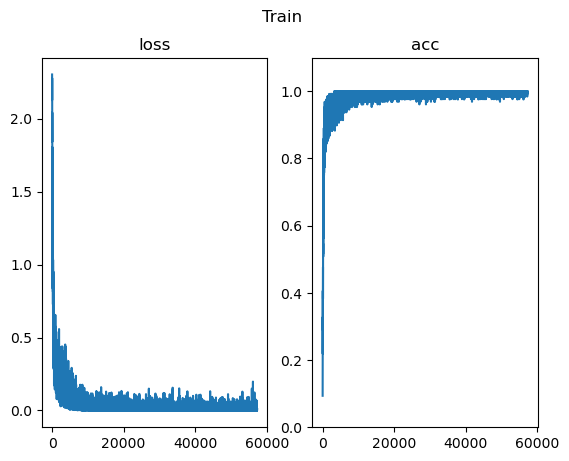

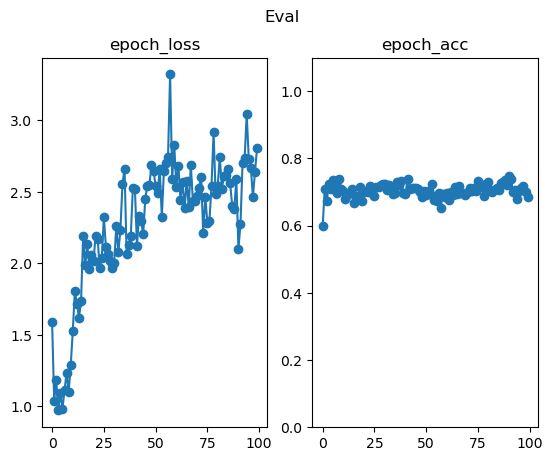

Eval_metrics: epoch_loss 2.806501626968384	epoch_acc 0.6858377456665039
Returning model from epoch: 90, eval_acc: 0.7471188306808472


In [22]:
hparams = OmegaConf.create({
    'epochs': 100,
    'batch_size': 128,
    'lr': 0.001,
    'beta1': 0.99,
})
eval_fn = create_and_train_classifier(hparams, ds_svhn, eval_data=ds_mnist_dev) 

------------------------------ epoch 99 ------------------------------


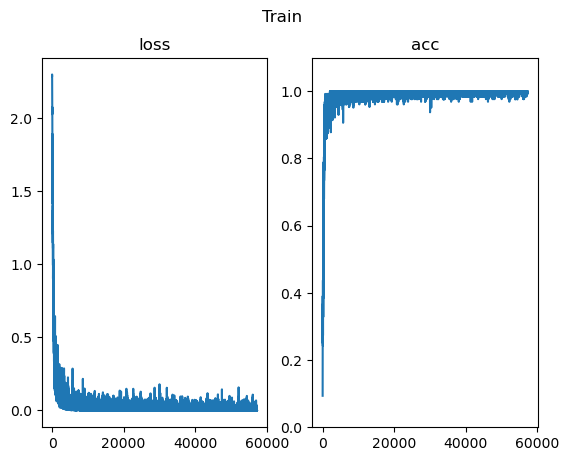

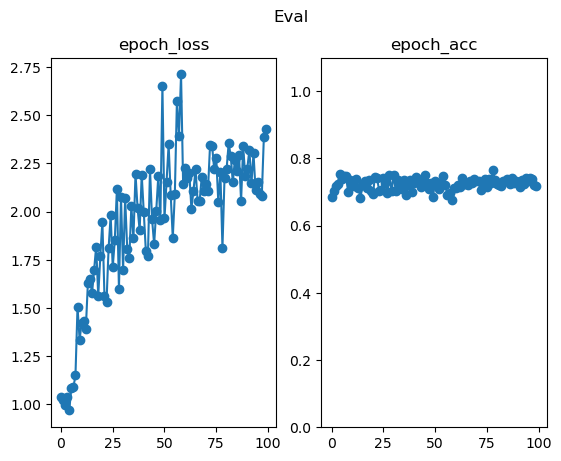

Eval_metrics: epoch_loss 2.430950403213501	epoch_acc 0.7187222838401794
Returning model from epoch: 78, eval_acc: 0.765625


In [23]:
hparams = OmegaConf.create({
    'epochs': 100,
    'batch_size': 128,
    'lr': 0.0001,
    'beta1': 0.5,
})
eval_fn = create_and_train_classifier(hparams, ds_svhn, eval_data=ds_mnist_dev) 

## Domain adaptation: DANN

In this part we will implement the
[DANN](https://www.jmlr.org/papers/volume17/15-239/15-239.pdf)
model and use to for SVHN &rarr; MNIST adaptation.

As shown on the figure below, DANN has three component networks: feature extractor, label predictor, and domain classifier.
Label predictor is trained with only source data, as for target data no labels are used.
The goal of the domain classifier (discriminator) is to distinguish features of the source vs. target domain samples. Therefore, in order to fool the discriminator, the feature extractor (generator) has to make the features of source and domain samples indistinguishable, while preserving enough relevant information to allow the label predictor still correctly classify source samples.

In GAN training, one typically uses two separate updates, separate for the generator and discriminator.
DANN however, introduced a _Gradient Reversal Layer_ which reverses the gradients from the discriminator. Thanks to that  all components can updated with just a single update.

![DANN figure](./imgs/dann_figure.svg)

<div align="center">
    Source: <a href="https://www.jmlr.org/papers/volume17/15-239/15-239.pdf">DANN</a>
</div>

### (Task) Implement _gradient reversal layer_

The layer should in the forward pass behave like an identity function. However, in the backward pass it should reverse the gradients and multiply them by `l`.

You might want to remind yourself how automatic differentation, back propagation, and chain rule of derivatives work!

In [24]:
@jax.custom_jvp
def grad_reverse(x, l):
    # Just an identify function in the forward pass
    return x

@grad_reverse.defjvp
def grad_reverse_jvp(primals, tangents):
    # Reverse the gradients and multiply by the constant `l`
    
    raise NotImplementedError('Task: implement!')

In [25]:
from solutions import grad_reverse

In [26]:
grad_reverse(jnp.array(5.), 2)

DeviceArray(5., dtype=float32)

#### (Task) Test _gradient reversal layer_

In [27]:
l = 0.5
def f(x):
    return jnp.sin(grad_reverse(x, l)) * 5.

x = jnp.array(-5.)

np.testing.assert_almost_equal(x, grad_reverse(x, l))

jax.grad(f)(x), jax.grad(jnp.sin)(x) * 5. * l
expected = jax.grad(jnp.sin)(x) * 5. * l * -1.
returned = jax.grad(f)(x)
np.testing.assert_almost_equal(returned, expected)

### (Task) Implement DANN model

Task: Implement the training as in DANN model, using the model architecture as provided.
Remember to use the _gradient reversal layer_ and that you need to only one update for all the component networks.

The model should be optimized for the sum of classification loss on the source data and domain discrimination loss (weighted by `hparams.gan_loss_weight`).

In [28]:
# You can copy/re-use the functions from Part 1
from solutions import generator_loss, discriminator_loss

In [29]:
def create_discriminator():
    return stax.serial(
        stax.Dense(128, W_init=w_init), stax.BatchNorm(axis=0), stax.LeakyRelu,
        stax.Dense(128, W_init=w_init), stax.LeakyRelu,
        stax.Dense(1, W_init=w_init)
    )

In [30]:
def adaptation_weight(step, num_steps):
    p = jnp.clip(step / num_steps, 0., 1.)
    l = 2 / (1 + jnp.exp(-10. * p)) - 1
    return l

In [31]:
def create_and_train_classifier_dann(hparams, src_data, tar_data, eval_data=None):
    
    cnn_init, cnn_apply = create_cnn()
    dense_init, dense_apply = create_label_predictor()
    dis_init, dis_apply = create_discriminator()
    
    key = jax.random.PRNGKey(seed)
    key, key_cnn, key_pred, key_dis = jax.random.split(key, 4)
    data_input_shape = (-1, 32, 32, 3)
    cnn_output_shape, cnn_params = cnn_init(key_cnn, data_input_shape)
    _, dense_params = dense_init(key_pred, cnn_output_shape)
    _, dis_params = dis_init(key_dis, cnn_output_shape)
    
    def split_params(params):
        n = (len(cnn_params), len(dense_params), len(dis_params))
        return (
            params[:n[0]],
            params[n[0]:n[0] + n[1]],
            params[n[0] + n[1]:]
        )
    
    opt_init, opt_update, get_params = optimizers.adam(
        step_size=hparams.lr, b1=hparams.beta1
    )
    opt_state = opt_init(cnn_params + dense_params + dis_params)
    
    def loss_fn_classification(cnn_params, dense_params, x, y):
        # Used for evaluation
        pred_y_logits = dense_apply(dense_params, cnn_apply(cnn_params, x))
        loss = jnp.mean(
            sparse_softmax_cross_entropy(targets=y, logits=pred_y_logits),
            axis=0
        )
        return loss, pred_y_logits
    
    def evaluate(opt_state, eval_data):
        cnn_params, dense_params, _ = split_params(get_params(opt_state))
        
        loss_fn_cls_jit = jax.jit(loss_fn_classification)
        
        loss_vals, acc_vals = [], []
        for i, (x, y) in enumerate(tqdm.tqdm(
            tfds.as_numpy(eval_data.batch(hparams.batch_size).prefetch(tf.data.experimental.AUTOTUNE)),
            desc='evaluation'
        )):
            loss, pred_y_logits = loss_fn_cls_jit(cnn_params, dense_params, x, y)
            acc = accuracy(y, jnp.argmax(pred_y_logits, axis=-1))
            loss_vals.append(loss)
            acc_vals.append(acc)
            
        return jnp.array(loss_vals).mean(), jnp.array(acc_vals).mean()
    
    @jax.jit
    def train_step(step, opt_state, x_src, y_src, x_tar):
        cnn_params, dense_params, dis_params = split_params(get_params(opt_state))
        
        # For `hparams.dynamic_adaptation_weight == True`
        # use provided `adaptation_weight(.)` function
        
        raise NotImplementedError('Task: implement!')
        loss = NotImplemented
        cls_loss = NotImplemented
        dis_loss = NotImplemented
        pred_src_logits = NotImplemented
        opt_state = NotImplemented
        
        return (loss, cls_loss, dis_loss), pred_src_logits, opt_state
    
    
    metrics = {'loss': [], 'cls_loss': [], 'dis_loss': [], 'acc': []}
    eval_metrics = {'epoch_loss': [], 'epoch_acc': []}
    best_model = {'epoch': -1, 'eval_acc': -1., 'opt_state': None}
    
    total_step = 0
    tar_data_iter = tar_data.repeat()\
        .batch(hparams.batch_size).prefetch(tf.data.experimental.AUTOTUNE)\
        .as_numpy_iterator()
    
    try:
        for epoch in range(hparams.epochs):
            for x_src, y_src in tqdm.tqdm(
                tfds.as_numpy(src_data.batch(hparams.batch_size).prefetch(tf.data.experimental.AUTOTUNE)),
                desc='training'
            ):
                
                x_tar, _ = next(tar_data_iter)
                
                (loss, cls_loss, dis_loss), pred_src_logits, opt_state = train_step(
                    total_step, opt_state, x_src, y_src, x_tar)
                acc = accuracy(y_src, jnp.argmax(pred_src_logits, axis=-1))
                metrics['loss'].append(loss)
                metrics['cls_loss'].append(cls_loss)
                metrics['dis_loss'].append(dis_loss)
                metrics['acc'].append(acc)
                
                total_step += 1
                
            if eval_data is not None:
                eval_loss, eval_acc = evaluate(opt_state, eval_data=eval_data)
                eval_metrics['epoch_loss'].append(eval_loss)
                eval_metrics['epoch_acc'].append(eval_acc)
                
                if eval_acc > best_model['eval_acc']:
                    best_model = {'epoch': epoch, 'eval_acc': eval_acc, 'opt_state': opt_state}
                
            clear_output()
            print('-' * 30, 'epoch', epoch, '-' * 30)
            plot_metrics(metrics, title='Train')
            if eval_data is not None:
                plot_metrics(eval_metrics, title='Eval')
                print(f'Eval_metrics: epoch_loss {eval_metrics["epoch_loss"][-1]}'
                      f'\tepoch_acc {eval_metrics["epoch_acc"][-1]}')

                        
    except KeyboardInterrupt:
        print(f'Interrupted at epoch {epoch}.')

    print(f'Returning model from epoch: {best_model["epoch"]}, eval_acc: {best_model["eval_acc"]}')
    cnn_params, dense_params, dis_params = split_params(get_params(best_model['opt_state']))
    return {
        'eval_fn': functools.partial(evaluate, best_model['opt_state']),
        'cnn': (cnn_apply, cnn_params),
        'dense': (dense_apply, dense_params),
        'dis': (dis_apply, dis_params)
    }

After implementing the model, try to train it with a few different settings of hyperpameters.

Can you get results similar to the following?

![image.png](./imgs/step3_dann_training.png)
<div align="center">
    Evaluation on MNIST-dev
</div>

**How is it possible that the DANN model evaluated on data (MNIST) has a high accuracy but also such an insanely high cross-entropy?**<small>(The cross-entropy was actually much lower when no domain adaptation was done!)</small>
- Can you explain it?
- Note that on 10-class classification by random chance one could expect the cross-entropy of 2.3

If you have some hypotheses about possible explainations, but also the reasons why it happen, try to verify them by investigating the trained models (returned from the function), or possibly even running some additional experiments.

In [ ]:
hparams_dann = OmegaConf.create({
    'epochs': 100,
    'batch_size': 128,
    'lr': 0.0001,
    'gan_loss_weight': 0.5,
    'beta1': 0.5,
    'num_steps': 10000,
    'dynamic_adaptation_weight': False,
})
model = create_and_train_classifier_dann(
    hparams_dann,
    src_data=ds_svhn, tar_data=ds_mnist,
    eval_data=ds_mnist_dev)

In [35]:
model['eval_fn'](ds_mnist_test)

evaluation: 79it [00:04, 17.87it/s]


(DeviceArray(2.3872995, dtype=float32), DeviceArray(0.833663, dtype=float32))

In [ ]:
hparams_dann = OmegaConf.create({
    'epochs': 100,
    'batch_size': 128,
    'lr': 0.0001,
    'gan_loss_weight': 0.5,
    'beta1': 0.5,
    'num_steps': 10000,
    'dynamic_adaptation_weight': True,
})
model = create_and_train_classifier_dann(
    hparams_dann,
    src_data=ds_svhn, tar_data=ds_mnist,
    eval_data=ds_mnist_dev)

In [ ]:
hparams_dann = OmegaConf.create({
    'epochs': 100,
    'batch_size': 128,
    'lr': 0.0001,
    'gan_loss_weight': 1.,
    'beta1': 0.5,
    'num_steps': 10000,
    'dynamic_adaptation_weight': False,
})
model = create_and_train_classifier_dann(
    hparams_dann,
    src_data=ds_svhn, tar_data=ds_mnist,
    eval_data=ds_mnist_dev)

In [ ]:
hparams_dann = OmegaConf.create({
    'epochs': 100,
    'batch_size': 128,
    'lr': 0.001,
    'gan_loss_weight': 0.5,
    'beta1': 0.99,
    'num_steps': 10000,
    'dynamic_adaptation_weight': False,
})
model = create_and_train_classifier_dann(
    hparams_dann,
    src_data=ds_svhn, tar_data=ds_mnist,
    eval_data=ds_mnist_dev)


In [ ]:
hparams_dann = OmegaConf.create({
    'epochs': 100,
    'batch_size': 128,
    'lr': 0.0001,
    'gan_loss_weight': 1.,
    'beta1': 0.5,
    'num_steps': 10000,
    'dynamic_adaptation_weight': False,
})
model = create_and_train_classifier_dann(
    hparams_dann,
    src_data=ds_svhn, tar_data=ds_mnist,
    eval_data=ds_mnist_dev)

Finally, it is valuable for us to know, how long did it take you to finish this practical?